In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!wget --no-check-certificate \
https://www.dropbox.com/s/mabohevg89kuh9n/data_ground.zip?dl=1 \
-O /tmp/data_ground.zip

--2023-02-25 13:14:30--  https://www.dropbox.com/s/mabohevg89kuh9n/data_ground.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/mabohevg89kuh9n/data_ground.zip [following]
--2023-02-25 13:14:31--  https://www.dropbox.com/s/dl/mabohevg89kuh9n/data_ground.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd4b49bf85aba59fc3655ae6b42.dl.dropboxusercontent.com/cd/0/get/B3JV5YyfYxrdHdDcNt_fsxSJKKD5g57XzT9Qha0gSN8VVmFOEDTF0mgW5sL5hqxx3-eiHouYlhd5revmWd3TrFWvbRD5Viz6d9WmtXkzMSXNrTv_93-iGP54hEbLVri0HfQovz8MVueGXCY8GbZ6BhxHOulpFggE16uOW5IKh4MEUg/file?dl=1# [following]
--2023-02-25 13:14:31--  https://ucd4b49bf85aba59fc3655ae6b42.dl.dropboxusercontent.com/cd/0/get/B3JV5YyfYxrdHdDcNt_fsxSJKKD5g57XzT9Qha0gSN8VVmFOEDTF0mgW5sL5hqxx3-eiH

In [14]:
import os
import zipfile

local_zip = '/tmp/data_ground.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [15]:
import os

# 기본 경로
base_dir = '/tmp/data_ground'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 훈련에 사용되는 고양이/개 이미지 경로
train_grass_dir = os.path.join(train_dir, 'grass')
train_soil_dir = os.path.join(train_dir, 'soil')
print(train_grass_dir)
print(train_soil_dir)

# 테스트에 사용되는 고양이/개 이미지 경로
validation_grass_dir = os.path.join(validation_dir, 'grass')
validation_soil_dir = os.path.join(validation_dir, 'soil')
print(validation_grass_dir)
print(validation_soil_dir)

#base_dir 안에 train(훈련 데이터 폴더) validation(테스트 데이터 폴더) 디렉토리를 생성 해주어야함

/tmp/data_ground/train/grass
/tmp/data_ground/train/soil
/tmp/data_ground/validation/grass
/tmp/data_ground/validation/soil


In [16]:
train_grass_fnames = os.listdir( train_grass_dir )
train_soil_fnames = os.listdir( train_soil_dir )

print(train_grass_fnames[:5])
print(train_soil_fnames[:5])

['934.tif', '472.tif', '1894.tif', '2141.tif', '509.tif']
['934.tif', '472.tif', '1894.tif', '2141.tif', '509.tif']


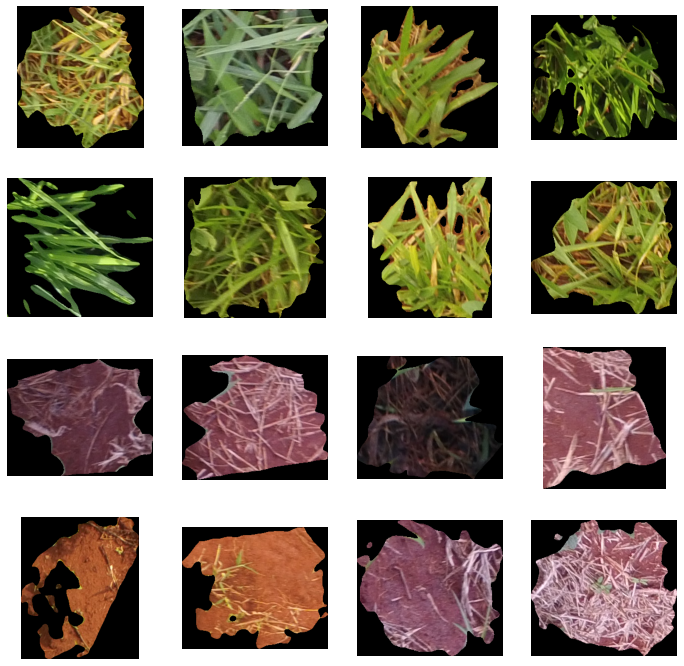

In [17]:
# 이미지 확인
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows, ncols = 4, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_grass_pix = [os.path.join(train_grass_dir, fname)
                for fname in train_soil_fnames[ pic_index-8:pic_index]]

next_soil_pix = [os.path.join(train_soil_dir, fname)
                for fname in train_soil_fnames[ pic_index-8:pic_index]]

for i, img_path in enumerate(next_grass_pix+next_soil_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [18]:
import tensorflow as tf


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [19]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics = ['accuracy'])

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                  batch_size=20,
                                                  class_mode='binary',
                                                  target_size=(150, 150))
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                       batch_size=20,
                                                       class_mode  = 'binary',
                                                       target_size = (150, 150))

Found 4702 images belonging to 2 classes.
Found 2067 images belonging to 2 classes.


In [21]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_steps=50,
                    verbose=2)

Epoch 1/100
100/100 - 22s - loss: 0.3049 - accuracy: 0.9137 - val_loss: 0.0331 - val_accuracy: 0.9920 - 22s/epoch - 219ms/step
Epoch 2/100
100/100 - 12s - loss: 0.0805 - accuracy: 0.9735 - val_loss: 0.0265 - val_accuracy: 0.9900 - 12s/epoch - 124ms/step
Epoch 3/100
100/100 - 11s - loss: 0.0280 - accuracy: 0.9910 - val_loss: 0.0261 - val_accuracy: 0.9930 - 11s/epoch - 110ms/step
Epoch 4/100
100/100 - 14s - loss: 0.0478 - accuracy: 0.9889 - val_loss: 1.1443 - val_accuracy: 0.7800 - 14s/epoch - 137ms/step
Epoch 5/100
100/100 - 12s - loss: 0.0482 - accuracy: 0.9870 - val_loss: 0.0703 - val_accuracy: 0.9770 - 12s/epoch - 121ms/step
Epoch 6/100
100/100 - 13s - loss: 0.0276 - accuracy: 0.9950 - val_loss: 0.0109 - val_accuracy: 0.9970 - 13s/epoch - 132ms/step
Epoch 7/100
100/100 - 11s - loss: 0.0242 - accuracy: 0.9945 - val_loss: 0.0044 - val_accuracy: 0.9990 - 11s/epoch - 113ms/step
Epoch 8/100
100/100 - 12s - loss: 0.0313 - accuracy: 0.9950 - val_loss: 0.0027 - val_accuracy: 1.0000 - 12s/epo

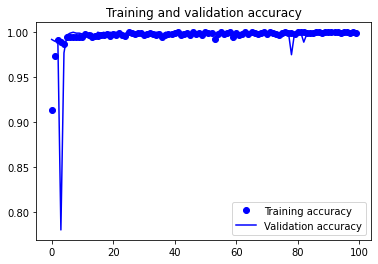

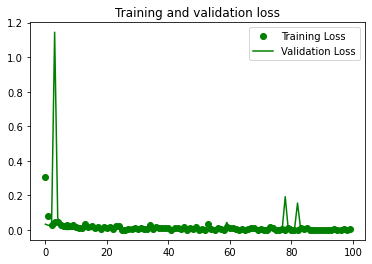

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Saving 스크린샷 2023-02-25 오후 10.53.35.png to 스크린샷 2023-02-25 오후 10.53.35.png
1/1 [==============================] - 0s 19ms/step
[0.]


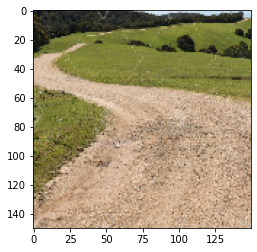

스크린샷 2023-02-25 오후 10.53.35.png is a grass


In [26]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():

  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))

  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0:
    plt.imshow(img)
    plt.show()
    print(fn + " is a soil")
  else:
    plt.imshow(img)
    plt.show()
    print(fn + " is a grass")